In [36]:
import torch
from torch.utils.data import Dataset
import random

class ArithmeticDataset(Dataset):
    def __init__(self, max_length, num_samples):
        self.max_length = max_length
        self.num_samples = num_samples
        self.data = self.generate_data()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    def generate_number(self, length):
        return random.randint(10**(length-1), 10**length - 1)

    def generate_data(self):
        raise NotImplementedError("Subclasses must implement this method")

In [37]:
class AdditionDataset(ArithmeticDataset):
    def generate_data(self):
        data = []
        samples_per_combination = self.num_samples // (self.max_length ** 2)
        for i in range(1, self.max_length + 1):
            for j in range(1, self.max_length + 1):
                for _ in range(samples_per_combination):
                    num1 = self.generate_number(i)
                    num2 = self.generate_number(j)
                    result = num1 + num2
                    data.append((f"{num1}+{num2}=", str(result)))
        return data

In [38]:
class MultiplicationDataset(ArithmeticDataset):
    def generate_data(self):
        data = []
        samples_per_combination = self.num_samples // (self.max_length ** 2)
        for i in range(1, self.max_length + 1):
            for j in range(1, self.max_length + 1):
                for _ in range(samples_per_combination):
                    num1 = self.generate_number(i)
                    num2 = self.generate_number(j)
                    result = num1 * num2
                    data.append((f"{num1}*{num2}=", str(result)))
        return data

In [39]:
class SortingDataset(ArithmeticDataset):
    def generate_data(self):
        data = []
        samples_per_combination = self.num_samples // (self.max_length ** 2)
        for i in range(1, self.max_length + 1):  # number of integers
            for j in range(1, self.max_length + 1):  # max digit length
                for _ in range(samples_per_combination):
                    numbers = [self.generate_number(random.randint(1, j)) for _ in range(i)]
                    indices = list('abcdefghijklmnopqrstuvwxyz'[:i])
                    input_str = ','.join([f"{idx}:{num}" for idx, num in zip(indices, numbers)])
                    sorted_indices = [idx for _, idx in sorted(zip(numbers, indices))]
                    output_str = ''.join(sorted_indices)
                    data.append((input_str, output_str))
        return data

In [40]:
def create_datasets(dataset_class, max_length, train_samples, test_samples):
    train_dataset = dataset_class(max_length, train_samples)
    test_dataset = dataset_class(max_length, test_samples)
    return train_dataset, test_dataset

In [41]:
# Set parameters
max_length = 20  # maximum length of operands
train_samples = 200_000  # 20 million as mentioned in the paper
test_samples = 1_000  # adjust as needed

# Create datasets
addition_train, addition_test = create_datasets(AdditionDataset, max_length, train_samples, test_samples)
multiplication_train, multiplication_test = create_datasets(MultiplicationDataset, max_length, train_samples, test_samples)
sorting_train, sorting_test = create_datasets(SortingDataset, max_length, train_samples, test_samples)

# Print some samples
print("Addition sample:", addition_train[0])
print("Multiplication sample:", multiplication_train[0])
print("Sorting sample:", sorting_train[0])

Addition sample: ('4+5=', '9')
Multiplication sample: ('6*4=', '24')
Sorting sample: ('a:3', 'a')


In [42]:
import random

def print_samples(dataset, name, num_samples=10):
    print(f"\n{name} Samples:")
    for _ in range(num_samples):
        idx = random.randint(0, len(dataset) - 1)
        sample = dataset[idx]
        print(f"Input: {sample[0]}, Output: {sample[1]}")

# Sample from Addition dataset
print_samples(addition_train, "Addition")

# Sample from Multiplication dataset
print_samples(multiplication_train, "Multiplication")

# Sample from Sorting dataset
print_samples(sorting_train, "Sorting")


Addition Samples:
Input: 135748326+108631275=, Output: 244379601
Input: 1354172+336685848355199866=, Output: 336685848356554038
Input: 44338320546283+972243690165=, Output: 45310564236448
Input: 75040161704634192095+9527451304538227395=, Output: 84567613009172419490
Input: 9318+84623911195379659736=, Output: 84623911195379669054
Input: 58739854+8279644088=, Output: 8338383942
Input: 9395564888+77629=, Output: 9395642517
Input: 520+2371=, Output: 2891
Input: 5623061952901691460+3=, Output: 5623061952901691463
Input: 243+4925787039520747=, Output: 4925787039520990

Multiplication Samples:
Input: 1314*4727797=, Output: 6212325258
Input: 3228169008960561*26=, Output: 83932394232974586
Input: 7035962375386837078*20466463929=, Output: 144001270161655858478286759462
Input: 4830844194151411*4972082029=, Output: 24019353602639217538092919
Input: 68464*476769075851088=, Output: 32641518009068888832
Input: 3517314548080498*75912257251479930246=, Output: 267007286808259638068510650232942508
Input

# Small Transformer for Arithmetic Tasks

This code implements a small transformer model designed to learn basic arithmetic operations, inspired by the Abacus Embeddings paper. The model architecture is as follows:

## Model Architecture
- Embedding layer: Custom Abacus Embedding
- Transformer layers: 2
- Attention heads per layer: 2
- Embedding dimension: 64
- Feed-forward dimension: 128
- Maximum sequence length: 20

## Key Components
1. **AbacusEmbedding**: A custom embedding layer that combines token embeddings with positional information.
2. **SmallTransformer**: The main model class, incorporating the Abacus Embedding and transformer layers.
3. **Training Loop**: Includes both training and evaluation phases, tracking loss and accuracy.

## Training Details
- Dataset: Addition task (can be extended to multiplication and sorting)
- Batch size: 32
- Number of epochs: 10
- Optimizer: Adam
- Learning rate: 0.001
- Loss function: Cross Entropy Loss (ignoring padding tokens)

This setup allows for quick experimentation and debugging on a CPU. Once the basic functionality is verified, the model size and dataset can be scaled up to match the specifications in the Abacus Embeddings paper.

Let's calculate the number of parameters for this model configuration. We'll break it down by component:

1. Embedding Layer:
   - Token Embedding: vocab_size * embed_size = 14 * 64 = 896
   - Positional Embedding: max_length * embed_size = 20 * 64 = 1,280

2. Transformer Layers (for each layer):
   - Self-Attention:
     * Query, Key, Value matrices: 3 * (embed_size * embed_size) = 3 * (64 * 64) = 12,288
     * Output projection: embed_size * embed_size = 64 * 64 = 4,096
   - Feed-forward network:
     * First linear layer: embed_size * ff_dim = 64 * 128 = 8,192
     * Second linear layer: ff_dim * embed_size = 128 * 64 = 8,192
   - Layer Norm (2 per layer): 2 * 2 * embed_size = 2 * 2 * 64 = 256

   Total per layer: 12,288 + 4,096 + 8,192 + 8,192 + 256 = 33,024

3. Output Layer:
   - Linear projection: embed_size * vocab_size = 64 * 14 = 896

Now, let's sum it up:
- Embedding Layer: 896 + 1,280 = 2,176
- Transformer Layers: 33,024 * 2 = 66,048
- Output Layer: 896

Total parameters: 2,176 + 66,048 + 896 = 69,120

So, this small transformer model would have approximately 69,120 parameters.

This is a very small model, which is perfect for initial experiments and debugging on a CPU. It's about 3 orders of magnitude smaller than the models described in the Abacus Embeddings paper (which mentions models with ~12 million parameters), allowing for quick iterations and tests of the basic architecture and training loop.

In [118]:
import torch
import random
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [119]:
import torch
from torch.utils.data import Dataset
import random

class AdditionDataset(Dataset):
    def __init__(self, max_length, num_samples):
        # Initialize the dataset with maximum length of numbers and total samples
        self.max_length = max_length
        self.num_samples = num_samples
        
        # Define the vocabulary for tokenization
        # 0-9 for digits, 10 for '+', 11 for '=', 12 for padding, 13 for end of sequence
        self.vocab = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 
                      '+': 10, '=': 11, '<PAD>': 12, '<EOS>': 13}
        # Create an inverse vocabulary for decoding
        self.inv_vocab = {v: k for k, v in self.vocab.items()}
        # Generate the dataset
        self.data = self.generate_data()

    def __len__(self):
        # Return the number of samples in the dataset
        return len(self.data)

    def __getitem__(self, idx):
        # Return a specific item from the dataset
        return self.data[idx]

    def generate_number(self, length):
        # Generate a random number of specified length
        return random.randint(10**(length-1), 10**length - 1)

    def tokenize(self, s):
        # Convert a string to a list of token IDs
        return [self.vocab[c] for c in s if c in self.vocab]

    def pad_sequence(self, seq, max_length):
        # Pad a sequence with <PAD> tokens to reach the specified length
        return seq + [self.vocab['<PAD>']] * (max_length - len(seq))

    def generate_data(self):
        data = []
        # Calculate samples per length combination to achieve desired total samples
        samples_per_combination = max(1, self.num_samples // (self.max_length ** 2))
        
        # Generate addition problems for all possible length combinations
        for i in range(1, self.max_length + 1):
            for j in range(1, self.max_length + 1):
                for _ in range(samples_per_combination):
                    # Generate two random numbers
                    num1 = self.generate_number(i)
                    num2 = self.generate_number(j)
                    result = num1 + num2
                    
                    # Create the input string (reversed for right-to-left processing)
                    input_str = f"{num1:0{i}}+{num2:0{j}}="
                    input_str = input_str[::-1]  # Reverse the string
                    
                    # Create the target string (reversed)
                    target_str = f"{result}"[::-1]
                    
                    # Tokenize and pad both input and target
                    input_tokens = self.tokenize(input_str)
                    target_tokens = self.tokenize(target_str) + [self.vocab['<EOS>']]
                    
                    max_seq_length = self.max_length * 2 + 2  # Maximum possible sequence length
                    input_padded = self.pad_sequence(input_tokens, max_seq_length)
                    target_padded = self.pad_sequence(target_tokens, max_seq_length)
                    
                    # Convert to PyTorch tensors
                    input_tensor = torch.tensor(input_padded, dtype=torch.long)
                    target_tensor = torch.tensor(target_padded, dtype=torch.long)
                    
                    data.append((input_tensor, target_tensor))
        
        # Shuffle the data for randomness
        random.shuffle(data)
        return data

    def decode(self, tensor):
        # Convert a tensor of token IDs back to a string, reversing and removing special tokens
        return ''.join(self.inv_vocab[t.item()] for t in tensor if t.item() not in [self.vocab['<PAD>'], self.vocab['<EOS>']])[::-1]

# Set parameters for the dataset
max_length = 20  # maximum length of operands
train_samples = 200_000  # Number of training samples
test_samples = 1_000  # Number of test samples

# Create training and test datasets
addition_train = AdditionDataset(max_length, train_samples)
addition_test = AdditionDataset(max_length, test_samples)

In [120]:
# Print some samples
print("Addition samples:")
for i in range(0,5):
    input_tensor, target_tensor = addition_train[i]
    input_str = addition_train.decode(input_tensor)
    target_str = addition_train.decode(target_tensor)
    print(f"Input: {input_str}")
    print(f"Target: {target_str}")
    print(f"Equation: {input_str} {target_str}")
    print()

Addition samples:
Input: 29458670367+59799239011929961529=
Target: 59799239041388631896
Equation: 29458670367+59799239011929961529= 59799239041388631896

Input: 8654772+427196354=
Target: 435851126
Equation: 8654772+427196354= 435851126

Input: 33530729735093760+8921=
Target: 33530729735102681
Equation: 33530729735093760+8921= 33530729735102681

Input: 62746988432+112950109=
Target: 62859938541
Equation: 62746988432+112950109= 62859938541

Input: 687204568054000123+2615962370626995680=
Target: 3303166938680995803
Equation: 687204568054000123+2615962370626995680= 3303166938680995803



In [121]:
class AbacusEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_size, max_length):
        super().__init__()
        # Create an embedding layer for the input tokens
        self.embed = nn.Embedding(vocab_size, embed_size)
        # Create a separate embedding layer for positional encodings
        self.pos_embed = nn.Embedding(max_length, embed_size)
        self.max_length = max_length
        
    def forward(self, x):
        # Get the sequence length of the input
        seq_length = x.size(1)
        
        # Generate position indices
        pos = torch.arange(seq_length, device=x.device).unsqueeze(0)
        
        # Truncate positions to max_length
        # This ensures that positions beyond max_length use the same embedding
        pos = torch.clamp(pos, max=self.max_length - 1)
        
        # Get the token embeddings
        embedded = self.embed(x)
        
        # Get the positional embeddings
        positional = self.pos_embed(pos)
        
        # Combine token embeddings and positional embeddings
        return embedded + positional[:, :seq_length]

In [122]:
class SmallTransformer(nn.Module):
    def __init__(self, vocab_size, embed_size, num_heads, ff_dim, num_layers, max_length):
        super().__init__()
        # Initialize the custom Abacus Embedding layer
        self.embedding = AbacusEmbedding(vocab_size, embed_size, max_length)
        
        # Create a single Transformer encoder layer
        self.transformer_layer = nn.TransformerEncoderLayer(
            d_model=embed_size,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            batch_first=True
        )
        
        # Create the full Transformer encoder by stacking multiple layers
        self.transformer = nn.TransformerEncoder(self.transformer_layer, num_layers=num_layers)
        
        # Final linear layer to project to vocabulary size
        self.fc_out = nn.Linear(embed_size, vocab_size)
        
    def forward(self, x):
        try:
            # Apply Abacus Embedding
            x = self.embedding(x)
            
            # Pass through the Transformer encoder
            x = self.transformer(x)
            
            # Project to vocabulary size
            return self.fc_out(x)
        except Exception as e:
            print(f"Error in SmallTransformer forward pass: {str(e)}")
            raise e

In [123]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import time
import random

class Head(nn.Module):
    def __init__(self, head_size, embed_size, dropout=0.1):
        super().__init__()
        self.key = nn.Linear(embed_size, head_size, bias=False)
        self.query = nn.Linear(embed_size, head_size, bias=False)
        self.value = nn.Linear(embed_size, head_size, bias=False)
        self.dropout = nn.Dropout(dropout)
        
        # For scale in attention computation
        self.scale = head_size ** -0.5
        
    def forward(self, x, mask=None):
        B, T, C = x.shape # batch size, sequence length, channels, which is the embed_size so (32, 42, 64)
        
        # Create key, query, value projections
        k = self.key(x)    # (B, T, head_size)
        q = self.query(x)  # (B, T, head_size)
        v = self.value(x)  # (B, T, head_size)
        
        # Compute attention scores
        att = (q @ k.transpose(-2, -1)) * self.scale  # (B, T, T)
        
        # Apply mask if provided (for causal attention)
        if mask is not None:
            att = att.masked_fill(mask == 0, float('-inf'))
            
        # Apply softmax and dropout
        att = F.softmax(att, dim=-1)
        att = self.dropout(att)
        
        # Weighted aggregation of values
        out = att @ v  # (B, T, head_size)
        return out

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size, embed_size, dropout=0.1):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size, embed_size, dropout) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, embed_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        # Concatenate outputs from all heads
        out = torch.cat([h(x, mask) for h in self.heads], dim=-1)
        # Project back to embed_size
        out = self.dropout(self.proj(out))
        return out

class FeedForward(nn.Module):
    def __init__(self, embed_size, ff_dim, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embed_size, ff_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, embed_size),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        return self.net(x)

class ArithmeticTransformerBlock(nn.Module):
    def __init__(self, embed_size, num_heads, head_size, ff_dim, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadAttention(num_heads, head_size, embed_size, dropout)
        self.feed_forward = FeedForward(embed_size, ff_dim, dropout)
        self.ln1 = nn.LayerNorm(embed_size)
        self.ln2 = nn.LayerNorm(embed_size)
        
    def forward(self, x, mask=None):
        # Attention with residual connection and layer norm
        x = x + self.attention(self.ln1(x), mask)
        # Feed forward with residual connection and layer norm
        x = x + self.feed_forward(self.ln2(x))
        return x

class ArithmeticTransformer(nn.Module):
    def __init__(self, vocab_size, embed_size, num_heads, head_size, ff_dim, 
                 num_layers, max_length, dropout=0.1):
        super().__init__()
        # Keep the AbacusEmbedding layer
        self.embedding = AbacusEmbedding(vocab_size, embed_size, max_length)
        
        # Create stack of transformer blocks
        self.blocks = nn.ModuleList([
            ArithmeticTransformerBlock(embed_size, num_heads, head_size, ff_dim, dropout)
            for _ in range(num_layers)
        ])
        
        # Layer norm before final projection
        self.ln_f = nn.LayerNorm(embed_size)
        
        # Final projection to vocabulary
        self.fc_out = nn.Linear(embed_size, vocab_size)
        
    def forward(self, x):
        # Get embeddings
        x = self.embedding(x)
        
        # Pass through transformer blocks
        for block in self.blocks:
            x = block(x)
            
        # Final layer norm and projection
        x = self.ln_f(x)
        logits = self.fc_out(x)
        
        return logits

In [124]:
import time
from tqdm import tqdm

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    best_accuracy = 0
    for epoch in range(num_epochs):
        # Set the model to training mode
        model.train()
        total_loss = 0
        correct_predictions = 0
        total_predictions = 0
        start_time = time.time()

        # Create a progress bar for each epoch
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for batch_idx, (inputs, targets) in progress_bar:
            try:
                # Reset gradients
                optimizer.zero_grad()
                
                # Forward pass
                outputs = model(inputs)
                
                # Calculate loss
                loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))
                
                # Backward pass
                loss.backward()
                
                # Update weights
                optimizer.step()
                
                total_loss += loss.item()

                # Calculate accuracy for this batch
                _, predicted = outputs.max(dim=-1)
                non_pad_mask = targets.ne(addition_train.vocab['<PAD>'])
                correct_predictions += (predicted[non_pad_mask] == targets[non_pad_mask]).sum().item()
                total_predictions += non_pad_mask.sum().item()

                # Update progress bar with current loss and accuracy
                progress_bar.set_postfix({
                    'loss': f"{loss.item():.4f}",
                    'acc': f"{correct_predictions/total_predictions:.4f}"
                })

            except Exception as e:
                # Error handling and debugging information
                print(f"\nError in batch {batch_idx}")
                print(f"Input shape: {inputs.shape}, max value: {inputs.max().item()}, min value: {inputs.min().item()}")
                print(f"Target shape: {targets.shape}, max value: {targets.max().item()}, min value: {targets.min().item()}")
                print(f"Output shape: {outputs.shape}")
                raise e
        
        # Calculate average loss and accuracy for the epoch
        avg_loss = total_loss / len(train_loader)
        train_accuracy = correct_predictions / total_predictions
        epoch_time = time.time() - start_time

        print(f'\nEpoch {epoch+1}/{num_epochs} - Time: {epoch_time:.2f}s')
        print(f'Train Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
        
        # Evaluation on test set
        model.eval()  # Set the model to evaluation mode
        correct = 0
        total = 0
        test_loss = 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                _, predicted = outputs.max(dim=-1)
                non_pad_mask = targets.ne(addition_train.vocab['<PAD>'])
                total += non_pad_mask.sum().item()
                correct += (predicted[non_pad_mask] == targets[non_pad_mask]).sum().item()
                
                # Calculate test loss
                loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))
                test_loss += loss.item()

        # Calculate test accuracy and average test loss
        test_accuracy = correct / total
        avg_test_loss = test_loss / len(test_loader)
        print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

        # Save the best model
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'New best model saved with accuracy: {best_accuracy:.4f}')

        print('-' * 60)

    print(f'Training completed. Best test accuracy: {best_accuracy:.4f}')

In [135]:
def train_model_with_embedding_tracking(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    # Characters to track (digits and operators)
    chars_to_track = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '=']
    char_indices = [addition_train.vocab[c] for c in chars_to_track]
    
    # Storage for histories
    embedding_history = []
    loss_history = []
    global_steps = []
    best_accuracy = 0
    total_steps = 0
    
    for epoch in range(num_epochs):
        # Set the model to training mode
        model.train()
        total_loss = 0
        correct_predictions = 0
        total_predictions = 0
        start_time = time.time()
        
        # Create a progress bar for each epoch
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), 
                          desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for batch_idx, (inputs, targets) in progress_bar:
            try:
                # Reset gradients
                optimizer.zero_grad()
                
                # Forward pass
                outputs = model(inputs)
                
                # Calculate loss
                loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))
                
                # Backward pass
                loss.backward()
                
                # Update weights
                optimizer.step()
                
                total_loss += loss.item()
                
                # Calculate accuracy for this batch
                _, predicted = outputs.max(dim=-1)
                non_pad_mask = targets.ne(addition_train.vocab['<PAD>'])
                correct_predictions += (predicted[non_pad_mask] == targets[non_pad_mask]).sum().item()
                total_predictions += non_pad_mask.sum().item()
                
                # Store embeddings every 100 batches
                if batch_idx % 100 == 0:
                    # Fixed: Access embedding through the correct path
                    current_embeddings = model.embedding.embed.weight[char_indices].detach().numpy()
                    embedding_history.append(current_embeddings)
                    loss_history.append(loss.item())
                    global_steps.append(total_steps)
                
                # Update progress bar
                progress_bar.set_postfix({
                    'loss': f"{loss.item():.4f}",
                    'acc': f"{correct_predictions/total_predictions:.4f}"
                })
                
                total_steps += 1
                
            except Exception as e:
                print(f"\nError in batch {batch_idx}")
                print(f"Input shape: {inputs.shape}, max value: {inputs.max().item()}, min value: {inputs.min().item()}")
                print(f"Target shape: {targets.shape}, max value: {targets.max().item()}, min value: {targets.min().item()}")
                print(f"Output shape: {outputs.shape}")
                raise e
        
        # Calculate average loss and accuracy for the epoch
        avg_loss = total_loss / len(train_loader)
        train_accuracy = correct_predictions / total_predictions
        epoch_time = time.time() - start_time
        
        print(f'\nEpoch {epoch+1}/{num_epochs} - Time: {epoch_time:.2f}s')
        print(f'Train Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
        
        # Evaluation on test set
        model.eval()
        correct = 0
        total = 0
        test_loss = 0
        
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                _, predicted = outputs.max(dim=-1)
                non_pad_mask = targets.ne(addition_train.vocab['<PAD>'])
                total += non_pad_mask.sum().item()
                correct += (predicted[non_pad_mask] == targets[non_pad_mask]).sum().item()
                
                # Calculate test loss
                loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))
                test_loss += loss.item()
        
        # Calculate test accuracy and average test loss
        test_accuracy = correct / total
        avg_test_loss = test_loss / len(test_loader)
        print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
        
        # Save the best model
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_accuracy,
            }, 'best_arithmetic_model.pth')
            print(f'New best model saved with accuracy: {best_accuracy:.4f}')
        
        print('-' * 60)
    
    # Convert histories to numpy arrays
    embedding_history = np.array(embedding_history)
    loss_history = np.array(loss_history)
    global_steps = np.array(global_steps)
    
    return model, embedding_history, loss_history, global_steps, chars_to_track

In [133]:
'''
# Model parameters
vocab_size = 14  # 0-9 digits <PAD>, <EOS>, +, =,
embed_size = 64
num_heads = 2
ff_dim = 128
num_layers = 2
max_length = 20

# Training parameters
batch_size = 32
num_epochs = 10
learning_rate = 0.001

# Create dataloaders
train_loader = DataLoader(addition_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(addition_test, batch_size=batch_size)

max_seq_length = max_length * 2 + 2  # This should be 42 based on your current setup
model = SmallTransformer(vocab_size, embed_size, num_heads, ff_dim, num_layers, max_seq_length)
criterion = nn.CrossEntropyLoss(ignore_index=vocab_size-2)  # Assuming <PAD> is the second to last token
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs)
'''

"""
Training Configuration for Arithmetic Transformer

Model Architecture Parameters:
- vocab_size = 14: Vocabulary consists of digits 0-9 and special tokens (+, =, <PAD>, <EOS>)
- embed_size = 64: Dimension of the embedding vectors
- num_heads = 2: Number of attention heads in transformer
- head_size = 32: Size of each attention head (embed_size // num_heads)
- ff_dim = 256: Feed-forward network dimension (4x embed_size for better capacity)
- num_layers = 2: Number of transformer blocks
- max_length = 20: Maximum length of individual numbers
- max_seq_length = 42: Total sequence length (max_length * 2 + 2 for two numbers plus operators)

Training Configuration:
- batch_size = 32: Process 32 addition problems simultaneously
- num_epochs = 10: Complete dataset processed 10 times
- learning_rate = 0.001: Step size for optimizer

Data Processing:
- The dataset contains 200,000 unique addition problems
- These are processed in batches of 32 problems each
- Results in 6,250 batches per epoch (200,000/32)
- Each epoch processes all 200,000 problems in shuffled order
- By training end, each problem will have been practiced 10 times
- Total training examples processed: 2,000,000 (200,000 * 10 epochs)

Loss Function:
- CrossEntropyLoss with padding token ignored
- Padding token is second to last in vocabulary (index 12)

Optimization:
- Adam optimizer with standard parameters
- Learning rate of 0.001 balances learning speed and stability
"""


# Model parameters
vocab_size = 14  # 0-9 digits <PAD>, <EOS>, +, =
embed_size = 64
num_heads = 2
head_size = embed_size // num_heads  # 32 per head
ff_dim = embed_size * 4  # Common practice to use 4x embed_size
num_layers = 2
max_length = 20
max_seq_length = max_length * 2 + 2  # 42 for your setup, 2 numbers (max 20 digits each) + 2 operators

# Training parameters
batch_size = 32
num_epochs = 10
learning_rate = 0.001

# Create dataloaders
train_loader = DataLoader(addition_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(addition_test, batch_size=batch_size)

# Create the model
model = ArithmeticTransformer(
    vocab_size=vocab_size,
    embed_size=embed_size,
    num_heads=num_heads,
    head_size=head_size,
    ff_dim=ff_dim,
    num_layers=num_layers,
    max_length=max_seq_length,
    dropout=0.1
)

# Set up training criterion and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=vocab_size-2)  # Assuming <PAD> is the second to last token
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs)

Epoch 1/10:   1%|          | 41/6250 [00:02<06:52, 15.04it/s, loss=2.3783, acc=0.0991]


KeyboardInterrupt: 

In [137]:
# Model parameters
vocab_size = 14  # 0-9 digits <PAD>, <EOS>, +, =
embed_size = 64
num_heads = 2
head_size = embed_size // num_heads  # 32 per head
ff_dim = embed_size * 4  # Common practice to use 4x embed_size
num_layers = 2
max_length = 20
max_seq_length = max_length * 2 + 2  # 42 for your setup, 2 numbers (max 20 digits each) + 2 operators

# Training parameters
batch_size = 32
num_epochs = 3
learning_rate = 0.001

# Create datasets
train_samples = 200_000
test_samples = 1_000
addition_train = AdditionDataset(max_length, train_samples)
addition_test = AdditionDataset(max_length, test_samples)

# Create dataloaders
train_loader = DataLoader(addition_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(addition_test, batch_size=batch_size)

# Create the model
model = ArithmeticTransformer(
    vocab_size=vocab_size,
    embed_size=embed_size,
    num_heads=num_heads,
    head_size=head_size,
    ff_dim=ff_dim,
    num_layers=num_layers,
    max_length=max_seq_length,
    dropout=0.1
)

# Set up training criterion and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=vocab_size-2)  # Assuming <PAD> is the second to last token
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model with embedding tracking
model, embedding_history, loss_history, global_steps, chars_to_track = train_model_with_embedding_tracking(
    model, 
    train_loader, 
    test_loader, 
    criterion, 
    optimizer, 
    num_epochs
)


Epoch 1/3: 100%|██████████| 6250/6250 [04:59<00:00, 20.85it/s, loss=1.5418, acc=0.3628]



Epoch 1/3 - Time: 299.84s
Train Loss: 1.7137, Train Accuracy: 0.3628
Test Loss: 1.4692, Test Accuracy: 0.4373
New best model saved with accuracy: 0.4373
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 6250/6250 [03:29<00:00, 29.90it/s, loss=1.1592, acc=0.4868]



Epoch 2/3 - Time: 209.06s
Train Loss: 1.3682, Train Accuracy: 0.4868
Test Loss: 1.1929, Test Accuracy: 0.5485
New best model saved with accuracy: 0.5485
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 6250/6250 [03:30<00:00, 29.74it/s, loss=0.7269, acc=0.6340]



Epoch 3/3 - Time: 210.15s
Train Loss: 0.9683, Train Accuracy: 0.6340
Test Loss: 0.4973, Test Accuracy: 0.7942
New best model saved with accuracy: 0.7942
------------------------------------------------------------


In [138]:
'''
# After training completes, save the model with full configuration
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'vocab_size': vocab_size,
    'embed_size': embed_size,
    'num_heads': num_heads,
    'head_size': head_size,
    'ff_dim': ff_dim,
    'num_layers': num_layers,
    'max_seq_length': max_seq_length
}, 'arithmetic_model.pth')

print("Model training completed and saved!")

# Test the model on a few examples
print("\nTesting the trained model:")
'''


# Save the complete model state
save_path = 'arithmetic_model_embedding.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'embedding_history': embedding_history,
    'loss_history': loss_history,
    'global_steps': global_steps,
    'chars_to_track': chars_to_track,
    'model_config': {
        'vocab_size': vocab_size,
        'embed_size': embed_size,
        'num_heads': num_heads,
        'head_size': head_size,
        'ff_dim': ff_dim,
        'num_layers': num_layers,
        'max_length': max_seq_length,
        'dropout': 0.1
    },
    'vocab': addition_train.vocab,
    'inv_vocab': addition_train.inv_vocab
}, save_path)

print(f"Model and training history saved to {save_path}")


Model and training history saved to arithmetic_model_embedding.pth


In [145]:
'''
# Load the saved model
checkpoint = torch.load('trained_addition_model.pth')

# Recreate the model architecture
loaded_model = SmallTransformer(
    checkpoint['vocab_size'],
    checkpoint['embed_size'],
    checkpoint['num_heads'],
    checkpoint['ff_dim'],
    checkpoint['num_layers'],
    checkpoint['max_seq_length']
)

# Load the model weights
loaded_model.load_state_dict(checkpoint['model_state_dict'])

# Set the model to evaluation mode
loaded_model.eval()

print("Model loaded successfully!")

# Function to preprocess input for the model
def preprocess_input(input_str, max_length):
    # Reverse the input string
    input_str = input_str[::-1]
    # Tokenize
    tokens = [addition_train.vocab[c] for c in input_str if c in addition_train.vocab]
    # Pad
    padded = tokens + [addition_train.vocab['<PAD>']] * (max_length - len(tokens))
    return torch.tensor(padded).unsqueeze(0)  # Add batch dimension

# Function to decode model output
def decode_output(output_tensor):
    _, predicted = output_tensor.max(2)
    decoded = ''.join([addition_train.inv_vocab[t.item()] for t in predicted[0] if t.item() not in [addition_train.vocab['<PAD>'], addition_train.vocab['<EOS>']]])
    return decoded[::-1]  # Reverse the output
'''

'''
# Load the saved model Arithmetic Transformer version
checkpoint = torch.load('arithmetic_model.pth')

# Recreate the model architecture
loaded_model = ArithmeticTransformer(
    checkpoint['vocab_size'],
    checkpoint['embed_size'],
    checkpoint['num_heads'],
    checkpoint['head_size'],
    checkpoint['ff_dim'],
    checkpoint['num_layers'],
    checkpoint['max_seq_length']
)

# Load the model weights
loaded_model.load_state_dict(checkpoint['model_state_dict'])

# Set the model to evaluation mode
loaded_model.eval()

print("Model loaded successfully!")

# Function to preprocess input for the model
def preprocess_input(input_str, max_length):
    # Reverse the input string
    input_str = input_str[::-1]
    # Tokenize
    tokens = [addition_train.vocab[c] for c in input_str if c in addition_train.vocab]
    # Pad
    padded = tokens + [addition_train.vocab['<PAD>']] * (max_length - len(tokens))
    return torch.tensor(padded).unsqueeze(0)  # Add

# Function to decode model output
def decode_output(output_tensor):
    _, predicted = output_tensor.max(2)
    decoded = []
    for token in predicted[0]:
        token_val = token.item()
        if token_val == addition_train.vocab['<EOS>']:
            break
        if token_val != addition_train.vocab['<PAD>']:
            decoded.append(addition_train.inv_vocab[token_val])
    return ''.join(decoded)[::-1]  # Reverse at the end
'''

# Load the complete saved state
checkpoint = torch.load('arithmetic_model_embedding.pth')

# Extract the model configuration
config = checkpoint['model_config']

# Recreate the model
loaded_model = ArithmeticTransformer(
    vocab_size=config['vocab_size'],
    embed_size=config['embed_size'],
    num_heads=config['num_heads'],
    head_size=config['head_size'],
    ff_dim=config['ff_dim'],
    num_layers=config['num_layers'],
    max_length=config['max_length'],
    dropout=config['dropout']
)

# Load the model state dictionary
loaded_model.load_state_dict(checkpoint['model_state_dict'])

# Create optimizer (if needed)
loaded_optimizer = optim.Adam(loaded_model.parameters(), lr=0.001)  # or whatever learning rate you want
loaded_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Load training history and data
loaded_embedding_history = checkpoint['embedding_history']
loaded_loss_history = checkpoint['loss_history']
loaded_global_steps = checkpoint['global_steps']
loaded_chars_to_track = checkpoint['chars_to_track']
loaded_vocab = checkpoint['vocab']
loaded_inv_vocab = checkpoint['inv_vocab']

# Set model to evaluation mode
loaded_model.eval()

print("Model and all components loaded successfully!")

Model and all components loaded successfully!


In [147]:
'''
def test_addition(num1, num2):
    input_str = f"{num1}+{num2}="
    input_tensor = preprocess_input(input_str, checkpoint['max_seq_length'])
    
    with torch.no_grad():
        output = loaded_model(input_tensor)
        
    result = decode_output(output)
    print(f"{num1} + {num2} = {result}")
    print(f"Correct result: {num1 + num2}")
    print(f"Model's prediction is {'correct' if int(result) == num1 + num2 else 'incorrect'}")
    
    # Return the predicted result as an integer
    return int(result)


# Test it
#test_addition(4, 5)
#test_addition(6, 6)
#test_addition(10670, 990)
#test_addition(12379, 9821)
#test_addition(9821, 12379)

# Test all possible single-digit additions
# And check model accuracy
correct = 0
total = 0
for i in range(10):
    for j in range(10):
        predicted = test_addition(i, j)
        total += 1
        if i + j == predicted:
            correct += 1
            
print(f"\nModel accuracy on single-digit additions: {correct/total:.4f}")

# Check Commutative Property, accuracy should be 1.0
correct = 0
total = 0
for i in range(10):
    for j in range(i, 10):
        predicted1 = test_addition(i, j)
        predicted2 = test_addition(j, i)
        total += 2
        if i + j == predicted1:
            correct += 1
        if i + j == predicted2:
            correct += 1

print(f"\nModel accuracy on commutative additions: {correct/total:.4f}")
'''

def test_addition(num1, num2):
    # Calculate max_seq_length from the model's config
    max_seq_length = checkpoint['model_config']['max_length']  # This is already set to max_length * 2 + 2
    
    input_str = f"{num1}+{num2}="
    input_tensor = preprocess_input(input_str, max_seq_length)
    
    with torch.no_grad():
        output = loaded_model(input_tensor)
        
    result = decode_output(output)
    print(f"{num1} + {num2} = {result}")
    print(f"Correct result: {num1 + num2}")
    print(f"Model's prediction is {'correct' if int(result) == num1 + num2 else 'incorrect'}")
    
    # Return the predicted result as an integer
    return int(result)

# Test single digit additions
print("Testing single-digit additions...")
correct = 0
total = 0
for i in range(10):
    for j in range(10):
        predicted = test_addition(i, j)
        total += 1
        if i + j == predicted:
            correct += 1
            
print(f"\nModel accuracy on single-digit additions: {correct/total:.4f}")

# Test commutative property
print("\nTesting commutative property...")
correct = 0
total = 0
for i in range(10):
    for j in range(i, 10):
        predicted1 = test_addition(i, j)
        predicted2 = test_addition(j, i)
        total += 2
        if i + j == predicted1:
            correct += 1
        if i + j == predicted2:
            correct += 1

print(f"\nModel accuracy on commutative additions: {correct/total:.4f}")

Testing single-digit additions...
0 + 0 = 0
Correct result: 0
Model's prediction is correct
0 + 1 = 1
Correct result: 1
Model's prediction is correct
0 + 2 = 2
Correct result: 2
Model's prediction is correct
0 + 3 = 3
Correct result: 3
Model's prediction is correct
0 + 4 = 4
Correct result: 4
Model's prediction is correct
0 + 5 = 5
Correct result: 5
Model's prediction is correct
0 + 6 = 16
Correct result: 6
Model's prediction is incorrect
0 + 7 = 17
Correct result: 7
Model's prediction is incorrect
0 + 8 = 18
Correct result: 8
Model's prediction is incorrect
0 + 9 = 19
Correct result: 9
Model's prediction is incorrect
1 + 0 = 1
Correct result: 1
Model's prediction is correct
1 + 1 = 2
Correct result: 2
Model's prediction is correct
1 + 2 = 3
Correct result: 3
Model's prediction is correct
1 + 3 = 4
Correct result: 4
Model's prediction is correct
1 + 4 = 5
Correct result: 5
Model's prediction is correct
1 + 5 = 6
Correct result: 6
Model's prediction is correct
1 + 6 = 7
Correct result: 

In [71]:
def debug_model_output(num1, num2):
    input_str = f"{num1}+{num2}="
    input_tensor = preprocess_input(input_str, checkpoint['max_seq_length'])
    
    with torch.no_grad():
        output = loaded_model(input_tensor)
        
    # Look at raw logits
    logits = output[0]  # Remove batch dimension
    
    # Print token probabilities for each position
    for pos in range(len(logits)):
        probs = F.softmax(logits[pos], dim=0)
        top_tokens = torch.topk(probs, 3)
        print(f"\nPosition {pos}:")
        for i, (prob, token_idx) in enumerate(zip(top_tokens.values, top_tokens.indices)):
            token = addition_train.inv_vocab[token_idx.item()]
            print(f"  Top {i+1}: Token '{token}' with probability {prob:.3f}")
    
    result = decode_output(output)
    print(f"\nFinal output: {result}")
    print(f"Correct result: {num1 + num2}")

# Test with a simple example
debug_model_output(5, 4)


Position 0:
  Top 1: Token '9' with probability 1.000
  Top 2: Token '0' with probability 0.000
  Top 3: Token '8' with probability 0.000

Position 1:
  Top 1: Token '1' with probability 0.618
  Top 2: Token '<EOS>' with probability 0.355
  Top 3: Token '0' with probability 0.011

Position 2:
  Top 1: Token '<EOS>' with probability 0.995
  Top 2: Token '1' with probability 0.005
  Top 3: Token '4' with probability 0.000

Position 3:
  Top 1: Token '<EOS>' with probability 1.000
  Top 2: Token '1' with probability 0.000
  Top 3: Token '8' with probability 0.000

Position 4:
  Top 1: Token '<EOS>' with probability 0.997
  Top 2: Token '3' with probability 0.002
  Top 3: Token '1' with probability 0.000

Position 5:
  Top 1: Token '<EOS>' with probability 0.999
  Top 2: Token '3' with probability 0.000
  Top 3: Token '8' with probability 0.000

Position 6:
  Top 1: Token '<EOS>' with probability 0.999
  Top 2: Token '3' with probability 0.001
  Top 3: Token '1' with probability 0.000

Po

In [9]:
import random

def generate_test_set(num_samples, max_digits):
    test_set = []
    for _ in range(num_samples):
        num1 = random.randint(1, 10**max_digits - 1)
        num2 = random.randint(1, 10**max_digits - 1)
        result = num1 + num2
        test_set.append((num1, num2, result))
    return test_set

# Generate a test set
num_test_samples = 1000
max_test_digits = 20  # Maximum number of digits in each operand
test_set = generate_test_set(num_test_samples, max_test_digits)

In [10]:
def evaluate_on_dataset(model, dataloader, dataset_name="Dataset"):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            _, predicted = outputs.max(2)
            
            # Create a mask for non-padding tokens
            non_pad_mask = targets.ne(addition_train.vocab['<PAD>'])
            
            # Count correct predictions
            correct += (predicted[non_pad_mask] == targets[non_pad_mask]).sum().item()
            total += non_pad_mask.sum().item()
    
    accuracy = correct / total
    print(f"{dataset_name} Accuracy: {accuracy:.4f}")
    return accuracy

# Create a DataLoader for the training data
train_loader_for_eval = DataLoader(addition_train, batch_size=32, shuffle=False)

# Evaluate on training data
train_accuracy = evaluate_on_dataset(loaded_model, train_loader_for_eval, "Training Data")

# Evaluate on test data for comparison
test_accuracy = evaluate_on_dataset(loaded_model, test_loader, "Test Data")

# Print comparison
print(f"\nAccuracy comparison:")
print(f"Training Data: {train_accuracy:.4f}")
print(f"Test Data:     {test_accuracy:.4f}")

Training Data Accuracy: 0.6875


NameError: name 'test_loader' is not defined

In [22]:
def test_larger_additions(model, max_seq_length, num_samples=100):
    correct = 0
    for _ in range(num_samples):
        num1 = random.randint(10**20, 10**30 - 1)  # 21 to 30 digit numbers
        num2 = random.randint(10**20, 10**30 - 1)
        true_result = num1 + num2
        
        input_str = f"{num1}+{num2}="
        input_tensor = preprocess_input(input_str, max_seq_length)
        
        with torch.no_grad():
            output = model(input_tensor)
        
        predicted_result = decode_output(output)
        
        try:
            if int(predicted_result) == true_result:
                correct += 1
        except ValueError:
            pass
    
    accuracy = correct / num_samples
    print(f"Accuracy on {num_samples} large number samples (21-30 digits): {accuracy:.4f}")

# Test on larger numbers
test_larger_additions(loaded_model, checkpoint['max_seq_length'])

def test_specific_patterns(model, max_seq_length):
    test_cases = [
        (999999, 1),  # Testing carry over
        (1, 999999),  # Testing different order
        (10**15 - 1, 1),  # Large number + small number
        (10**15, 10**15),  # Two large, round numbers
        (123456789, 987654321),  # Ascending + descending
    ]
    
    for num1, num2 in test_cases:
        input_str = f"{num1}+{num2}="
        input_tensor = preprocess_input(input_str, max_seq_length)
        
        with torch.no_grad():
            output = model(input_tensor)
        
        predicted_result = decode_output(output)
        true_result = num1 + num2
        
        print(f"{num1} + {num2} = {predicted_result} (True: {true_result})")
        print(f"Correct: {int(predicted_result) == true_result}")
        print()

# Test on specific patterns
print("Testing on specific addition patterns:")
test_specific_patterns(loaded_model, checkpoint['max_seq_length'])

Accuracy on 100 large number samples (21-30 digits): 0.0000
Testing on specific addition patterns:
999999 + 1 = 99991999900 (True: 1000000)
Correct: False

1 + 999999 = 11999000 (True: 1000000)
Correct: False

999999999999999 + 1 = 00999990099999990999999999999999900 (True: 1000000000000000)
Correct: False

1000000000000000 + 1000000000000000 = 0000011010002000000000000000 (True: 2000000000000000)
Correct: False

123456789 + 987654321 = 91951616571110877600 (True: 1111111110)
Correct: False



In [11]:
import torchinfo  # Better alternative to torchsummary for transformers

In [14]:
import torch
from torchinfo import torchinfo  # Better alternative to torchsummary for transformers

def summarize_transformer(model, batch_size=32, seq_length=42, vocab_size=None):
    """
    Provides a detailed summary of a transformer model using torchinfo.
    
    Args:
        model: The transformer model to analyze
        batch_size: Number of samples in a batch
        seq_length: Length of input sequences
        vocab_size: Size of vocabulary (if None, will use model's vocab_size if available)
    """
    # Create dummy input tensor with proper dtype
    if vocab_size is None:
        try:
            vocab_size = model.vocab_size
        except AttributeError:
            vocab_size = 1000  # default fallback
    
    # Generate random indices within vocab size range
    dummy_input = torch.randint(0, vocab_size, (batch_size, seq_length), dtype=torch.long)
    
    # Get model summary
    summary = torchinfo.summary(
        model,
        input_data=dummy_input,
        col_names=["input_size", "output_size", "num_params", "kernel_size", "mult_adds"],
        depth=4,  # Adjust this to see more/less layers
        device='cpu'  # Change to 'cuda' if using GPU
    )
    
    return summary

# Example usage:
    # Get model summary
summary = summarize_transformer(
    loaded_model,
    batch_size=32,
    seq_length=42,
    vocab_size=checkpoint['vocab_size']
    )

print(summary)

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
SmallTransformer                              [32, 42]                  [32, 42, 14]              33,472                    --                        --
├─AbacusEmbedding: 1-1                        [32, 42]                  [32, 42, 64]              --                        --                        --
│    └─Embedding: 2-1                         [32, 42]                  [32, 42, 64]              896                       --                        28,672
│    └─Embedding: 2-2                         [1, 42]                   [1, 42, 64]               2,688                     --                        2,688
├─TransformerEncoder: 1-2                     [32, 42, 64]              [32, 42, 64]              --                        --                        --
│    └─ModuleList: 2-3                        --                    

# Small Transformer Model for Arithmetic Operations

This is a compact transformer model designed for arithmetic tasks. Here's a breakdown of its architecture:

## Model Overview
- **Total Parameters**: 104,910 (very lightweight!)
- **Memory Footprint**: Only 0.89 MB
- **Max Sequence Length**: 42 tokens
- **Embedding Dimension**: 64
- **Vocabulary Size**: 14 (likely digits 0-9 plus special tokens)

## Architecture Components

### 1. Input Processing (AbacusEmbedding)
- **Token Embedding**: Converts each input number/symbol into a 64-dimensional vector
- **Positional Embedding**: Adds position information to each token to maintain sequence order
- These embeddings combine to give the model understanding of both WHAT each token is and WHERE it appears

### 2. Transformer Encoder
- **Number of Layers**: 2
- Each layer contains:
 - Self-attention mechanism (allows model to weigh importance of different positions)
 - Feed-forward neural network
- Helps model understand relationships between different positions in the input sequence

### 3. Output Layer
- Linear projection layer that converts the 64-dimensional features back to vocabulary size (14)
- Produces predictions for each position in the sequence

This model's architecture suggests it's optimized for tasks like addition or basic arithmetic, where it needs to process sequences of numbers and operators. The small vocabulary size (14) is perfect for digits 0-9 plus a few special tokens (like '+', '=', etc.).

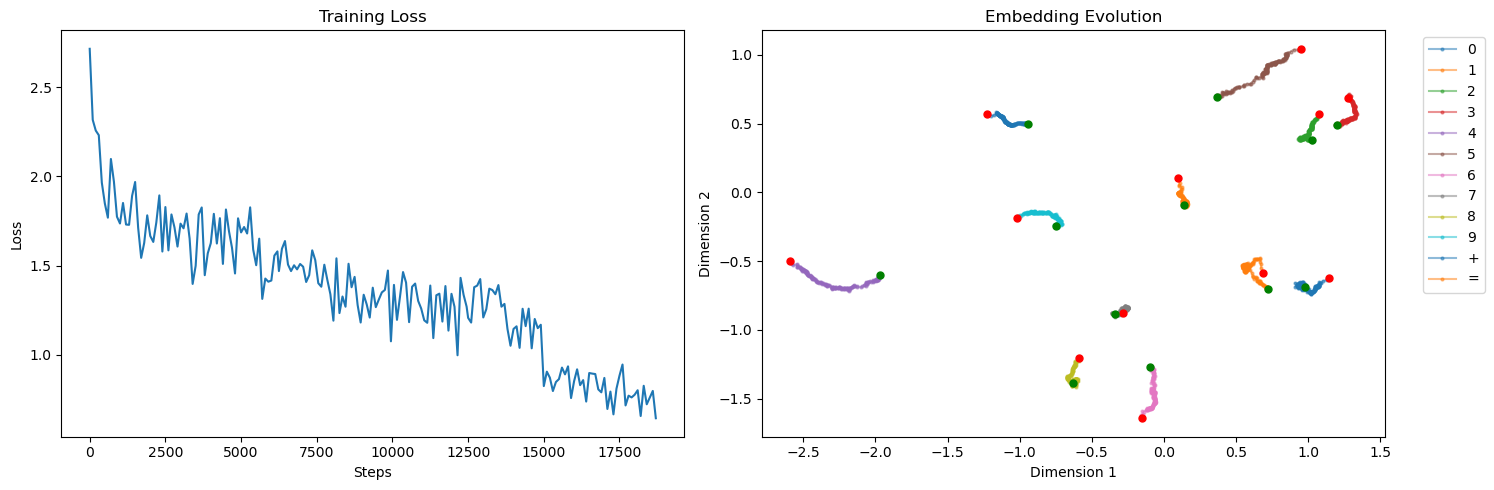

In [149]:
# Visualization function for embedding evolution
def visualize_embeddings(embedding_history, loss_history, global_steps, chars_to_track):
    """Visualize the evolution of embeddings and loss."""
    plt.figure(figsize=(15, 5))
    
    # Plot loss
    plt.subplot(121)
    plt.plot(global_steps, loss_history)
    plt.title('Training Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    
    # Plot embedding trajectories
    plt.subplot(122)
    for i, char in enumerate(chars_to_track):
        plt.plot(embedding_history[:, i, 0], 
                embedding_history[:, i, 1], 
                'o-', label=char, alpha=0.5,
                markersize=2)
        # Mark start and end positions
        plt.plot(embedding_history[0, i, 0],
                embedding_history[0, i, 1],
                'o', color='red', markersize=5)
        plt.plot(embedding_history[-1, i, 0],
                embedding_history[-1, i, 1],
                'o', color='green', markersize=5)
    
    plt.title('Embedding Evolution')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
# Visualize the embedding evolution
visualize_embeddings(loaded_embedding_history, loaded_loss_history, loaded_global_steps, loaded_chars_to_track)